<a href="https://colab.research.google.com/github/bawantha395/milk_quality_prediction/blob/main/next_word_prediction_newsHeadlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Literature Survey

Next-word prediction is a key task in natural language processing that involves predicting the next word in a sentence based on the preceding words. This project aims to develop a next-word prediction model using state-of-the-art deep learning techniques. The model will be built using Recurrent Neural Networks (RNNs) and their advanced variant, Long Short-Term Memory (LSTM) networks, known for their ability to capture long-term dependencies in text.By training these models on large text datasets, we aim to achieve high accuracy in predicting the next word, making the model useful for applications such as text completion, chatbots, and virtual assistants. The project will involve data preprocessing, model implementation, training, evaluation, and fine-tuning to optimize performance.

# Dataset Description

The dataset used in this project is sourced from Kaggle and contains news headlines from the month of March 2018.
The dataset provides a rich source of textual data suitable for training a next-word prediction model.
Each record in the dataset represents a single news headline.

In [2]:
!pip install keras tensorflow

import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Install opendatasets and download the dataset

In [3]:
!pip install opendatasets -q
import opendatasets as od

### Download the dataset

In [4]:
od.download("https://www.kaggle.com/datasets/manishguptads/news-headlines/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sulakshanitasheena
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/manishguptads/news-headlines


100%|██████████| 243k/243k [00:00<00:00, 585kB/s]

### Load the dataset

In [5]:
news_data = pd.read_csv("/content/news-headlines/ArticlesMarch2018.csv")
news_data.head()

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,01-03-2018 00:17,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,01-03-2018 00:40,Asia Pacific,The American military is looking at everything...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,01-03-2018 01:08,Unknown,Can you guess which man is the model public se...,The New York Times,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,01-03-2018 01:10,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,01-03-2018 01:14,Unknown,"Apollo, the private equity firm, and Citigroup...",The New York Times,News,https://www.nytimes.com/2018/02/28/business/ja...,1566


In [6]:
print("Number of records: ", news_data.shape[0])
print("Number of fields: ", news_data.shape[1])

Number of records:  1385
Number of fields:  15


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) involves analyzing the dataset to summarize its main characteristics, often using visual methods.
For this dataset, we can explore the distribution of headline lengths, the most common words, and other relevant statistics.


### Display the first few records and some basic statistics

In [7]:
print(news_data['headline'].head())
print(news_data['headline'].describe())

0                        Virtual Coins, Real Resources
1         U.S. Advances Military Plans for North Korea
2                   Mr. Trump and the ‘Very Bad Judge’
3       To Erase Dissent, China Bans Pooh Bear and ‘N’
4    Loans Flowed to Kushner Cos. After Visits to t...
Name: headline, dtype: object
count        1385
unique       1246
top       Unknown
freq          135
Name: headline, dtype: object


# Data Preprocessing

Data preprocessing is a crucial step in preparing the data for model training.
It includes tasks such as removing unwanted characters, tokenizing the text, and creating sequences of words for model input.

### Data cleaning

In [8]:
news_data['headline'] = news_data['headline'].apply(lambda x: x.replace(u'\xa0',u' '))
news_data['headline'] = news_data['headline'].apply(lambda x: x.replace('\u200a',' '))

### Tokenization

#####Tokenization is a process of extracting tokens (terms / words) from a corpus. Python’s library Keras has inbuilt model for tokenization which can be used to obtain the tokens and their index in the corpus. After this step, every text document in the dataset is converted into sequence of tokens.

In [9]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(news_data['headline'])

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as file:
    file.write(tokenizer_json)

total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])

Total number of words:  3693
Word: ID
------------
<oov>:  1
Strong:  3069
And:  7


### Creating sequences of words

In [10]:
input_sequences = []
for line in news_data['headline']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))

Total input sequences:  8290


### Pad sequences

In [24]:
max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1150, 1151,  126], dtype=int32)

In [23]:
max_length = max([len(input_sequence) for input_sequence in input_sequences])
max_length

19

### Create features and label

In [12]:
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [13]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   24   34 1153]
614
0.0


# Model Implementation

In this section, we implement the model for next-word prediction.
We use a Bidirectional LSTM model with an Embedding layer and a Dense layer with a softmax activation function.

### Define the model

In [14]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

### Compile the model

In [15]:
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 100)           369300    
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 3693)              1111593   
                                                                 
Total params: 1782093 (6.80 MB)
Trainable params: 1782093 (6.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Train the model



In [16]:
history = model.fit(xs, ys, epochs=50, verbose=1)

Epoch 1/50
260/260 [==============================] - 40s 116ms/step - loss: 7.6801 - accuracy: 0.0305
Epoch 2/50
260/260 [==============================] - 24s 94ms/step - loss: 6.7606 - accuracy: 0.0556
Epoch 3/50
260/260 [==============================] - 28s 109ms/step - loss: 5.7125 - accuracy: 0.1078
Epoch 4/50
260/260 [==============================] - 33s 129ms/step - loss: 4.3415 - accuracy: 0.2082
Epoch 5/50
260/260 [==============================] - 29s 113ms/step - loss: 2.9415 - accuracy: 0.3971
Epoch 6/50
260/260 [==============================] - 24s 94ms/step - loss: 1.8613 - accuracy: 0.5907
Epoch 7/50
260/260 [==============================] - 25s 96ms/step - loss: 1.2166 - accuracy: 0.7294
Epoch 8/50
260/260 [==============================] - 23s 88ms/step - loss: 0.8326 - accuracy: 0.8154
Epoch 9/50
260/260 [==============================] - 25s 95ms/step - loss: 0.6324 - accuracy: 0.8649
Epoch 10/50
260/260 [==============================] - 25s 95ms/step - loss: 0

# Model Evaluation and Discussion

Model evaluation involves assessing the performance of the model on the training data.
We use accuracy and loss metrics to evaluate the model during training.
We also visualize the training progress using plots..

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

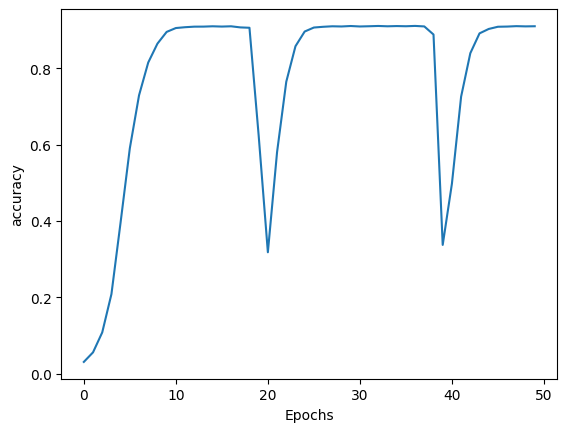

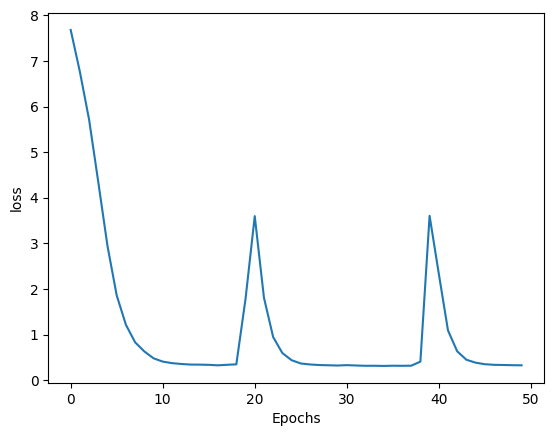

In [19]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Conclusion

In this project, we developed a next-word prediction model using a Bidirectional LSTM.
The model was trained on a dataset of news headlines, and we evaluated its performance using accuracy and loss metrics.
The results indicate that the model is capable of predicting the next word in a given sequence with reasonable accuracy.

# References

1. Gupta, M. (2021). News Headlines. Retrieved from https://www.kaggle.com/datasets/manishguptads/news-headlines/code

### Saving the model

In [20]:
model.save("next_word_prediction_model.h5")
# model.save("next_word_prediction_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Text Generation Function

This function takes a seed text and generates the next words based on the trained model.

In [21]:
def generate_text(model, tokenizer, seed_text, max_sequence_len, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

### Example usage

In [22]:
seed_text = "I am"
next_words = 5
generated_text = generate_text(model, tokenizer, seed_text, max_sequence_len, next_words)
print(generated_text)

I am goes so hollywood to last
